In [1]:
from sklearn.cluster import KMeans

import sklearn as sk
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd
import configparser
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
config = configparser.ConfigParser()
config.read('config.ini')
mapbox_token = config['mapbox']['secret_token']

In [3]:

# Read the CSV file
df = pd.read_csv('data/conflict_data.csv')

# Rename the features of the dataframe
df.rename(columns={'id': 'ID', 
                    'year': 'Year', 
                    'month': 'Month', 
                    'type_of_violence': 'Type',
                    'side_a': 'Side A',
                    'side_b': 'Side B',
                    'side_a_new_id': 'Side A ID',
                    'side_b_new_id': 'Side B ID',
                    'dyad_new_id': 'CID',
                    'dyad_name': 'Actors',
                    'where_coordinates': 'Location',
                    'where_prec': 'Where',
                    'latitude': 'Lat',
                    'longitude': 'Long',
                    'best': 'Casualties'}, inplace=True)

# Filter for the data we want to use
df = df[(df['Where'] < 5)]
df = df[df["ID"] != 121726]

# Output the head of the dataframe
df.head()

,ID,Year,Month,Type,Side A ID,Side A,Side B ID,Side B,Where,Location,Lat,Long,Casualties
0,125474,2009,8,1,5,Government of Philippines,9,MNLF,2,Matangguli island,8.163330,117.190000,3
1,125542,2009,8,1,5,Government of Philippines,9,MNLF,2,Matangguli island,8.163330,117.190000,7
2,124945,2012,12,1,5,Government of Philippines,6,CPP,1,Rizal town,8.680000,117.340000,1
3,238421,2017,2,1,5,Government of Philippines,11,ASG,2,Great Bakkungan island,6.187222,118.118888,1
4,124922,1999,6,1,5,Government of Philippines,6,CPP,3,Narra municipality,9.316667,118.400000,4


In [4]:

px.set_mapbox_access_token(mapbox_token)

# Create a scatter geo figure with the df as the data frame, and the lat and long features as the coordinates
fig2 = px.scatter_mapbox(
    df, 
    lat="Lat", 
    lon="Long"
)                        

# Update the plot to center on the Philippines
fig2.update_geos(
    center=dict(lat=14.5995, lon=120.9842),
    fitbounds="locations",
)

# Set the title and dimensions of the plot.
fig2.update_layout(
    height=500,
    width=800,
    title="Conflict Data",
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_token,
        center=go.layout.mapbox.Center(lat=11.75, lon=122.2691),
        bearing=0,
        pitch=0,
        zoom=4,
        style="light"
    )
)

# Show the Plot
fig2.show()

In [5]:
# Create a new dataframe with the data we want to use for K-Means clustering
df2 = df.drop(['ID', 'Where', 'Month', 'Location', 'Year', 'Side A', 'Side B', 'Casualties'], axis=1)

# Use skikit-learn preprocessing to normalize the data
X = sk.preprocessing.normalize(df2, axis=0, norm='max')

# Create a new dataframe with the normalized data
X = pd.DataFrame(X, columns=df2.columns)

# Print the head of the new dataframe
X.head()

,Type,Side A ID,Side B ID,Lat,Long
0,0.333333,0.208333,0.321429,0.442144,0.925964
1,0.333333,0.208333,0.321429,0.442144,0.925964
2,0.333333,0.208333,0.214286,0.470128,0.927149
3,0.333333,0.208333,0.392857,0.335114,0.933303
4,0.333333,0.208333,0.214286,0.504611,0.935525


In [6]:
# Create the inertial matrix for the data
inertia = []

# Create a for loop to iterate through the number of clusters to find the optimal cluster
optimal = 0
silhouette_score = 0
for i in range(2, 100):
    # Create a new K-Means model with the number of clusters
    kmeans = KMeans(n_clusters=i, 
                    n_init=10, 
                    tol=1e-4, 
                    random_state=42)
    # Fit the model to the data
    kmeans.fit(X)

    new_score = sk.metrics.silhouette_score(X, kmeans.labels_)

    optimal = i if new_score > silhouette_score else optimal

    silhouette_score = max(new_score, silhouette_score)

    # Append the inertia to the list
    inertia.append(kmeans.inertia_)

print(optimal)

5


In [7]:
# Create a figure to display the inertia values
fig = go.Figure(data=go.Scatter(x=np.arange(1,100), y=inertia))

# Update the layout of the plot to set the title and dimensions
fig.update_layout(
    title="Inertia vs Cluster Number",xaxis=dict(range=[0,100],title="Cluster Number"),
    yaxis={'title':'Inertia'},
    height=500,
    width=800,
    annotations=[
    dict(
        x=5,
        y=inertia[4],
        xref="x",
        yref="y",
        text="Elbow!",
        showarrow=True,
        arrowhead=7,
        ax=20,
        ay=-40
    )
])

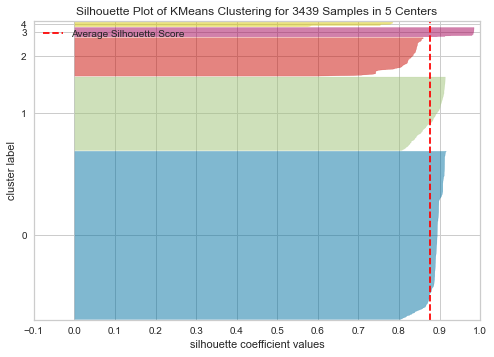

SSE: 40.07813226558054
0.28168925425311747 97


In [14]:
# Create a new K-Means model with the number of clusters of the elbow value
kmeans = KMeans(
    n_clusters=optimal,
    init="k-means++",
    n_init=10,
    random_state=42,
    tol=1e-4,
    max_iter=100
)

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
# Fit the visualizer to the data
visualizer.fit(X)
# Show the plot
visualizer.show()

# Create a new dataframe with the cluster labels
X['Cluster'] = kmeans.labels_.astype(str)

In [9]:
import warnings
warnings.filterwarnings("ignore")

polar = X.groupby("Cluster").mean().reset_index()
polar = pd.melt(polar,id_vars=["Cluster"])
fig4 = px.line_polar(polar, r="value", title="Cluster Parameters", theta="variable", color="Cluster", line_close=True, height=500, width=500)
fig4.show()

In [10]:
pie = X.groupby('Cluster').size().reset_index()
pie.columns=['Cluster','value']
px.pie(pie,values='value',names='Cluster', height=500,width=500, title="Cluster Distribution")

In [11]:
df['Cluster'] = kmeans.labels_
df['Cluster'] = df['Cluster'].astype(str)

px.set_mapbox_access_token(mapbox_token)
fig2 = px.scatter_mapbox(df, 
                        lat="Lat", 
                        lon="Long",
                        size="Casualties",
                        color="Cluster",
                        hover_name="Location",
                        hover_data=["ID", "Year", "Type", "Casualties", "Side A", "Side B"],
                        )
fig2.update_geos(
    fitbounds="locations",
)
fig2.update_layout(
    height=500,
    width=800,
    hovermode='closest',
    title="Conflict Clusters",
    mapbox=dict(
        accesstoken=mapbox_token,
        center=go.layout.mapbox.Center(lat=11.75, lon=122.2691),
        bearing=0,
        pitch=0,
        zoom=4,
        style="light",
        
    )
)
fig2.show()